In [1]:
!pip install transformers

     |████████████████████████████████| 1.5MB 11.4MB/s 
     |████████████████████████████████| 890kB 46.9MB/s 
     |████████████████████████████████| 2.9MB 45.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=b1b8ed2e841ef3abacb31fc697453ed620f9b51f8d2f4baf9026a56edcbf75a6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
# TRAINING OPTIONS:
# Run on TPU with smaller batches 
# OR 
# Switch to GPU if possible (MirroredStrategy), more memory needed

# To DOS
# Add load existing json and add epochs instead of replacing
# Add logging of losses mid-epoch
# How to log examples?
# Average loss over batches (not feasible in Colab TPU - memory issue)
# Play with hyperparameters (learning rate? margin?)

# OTHER:
# Set up other model (N1)
# Set up baseline model (BoW)

# TRIPLET MINING:
# Refine dataset building, creating hard vs. semi-hard triplets (same vs. different subreddit?)
# and computing loss on subsets of these

# GENERAL ISSUES
# Benchmarks
# Better / more informed dataset building (e.g. exploiting same vs. different subreddit?)
# Better / more informed loss calculation (e.g. only for "hard" triplets?)
# Better dataset inspection (make it possible to pull out negative/positive pair text - maybe embed tokenization in dataset building?)

In [2]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Input
from transformers import TFDistilBertModel
import glob
from tensorflow.keras.utils import Progbar
from google.colab import drive
import os
from pathlib import Path
import json
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [3]:
drive.mount('/content/drive/')
%cd 'drive/My Drive/personality_reddit'

Mounted at /content/drive/
/content/drive/My Drive/personality_reddit


In [5]:
from tools.datasets import load_tfrecord_triplet_nn1

## Initialize TPU strategy

In [6]:
try:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address)
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
  print("Number of accelerators: ", strategy.num_replicas_in_sync)
except ValueError:
  print('TPU failed to initialize.')

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.26.183.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.26.183.18:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.26.183.18:8470']
Number of accelerators:  8


In [7]:
AUTO = tf.data.experimental.AUTOTUNE

## Load and split dataset

In [8]:
batch_size = 1 # >1 not feasible on Colab TPUs - crashes at 10Gb requirement
global_batch_size = batch_size * strategy.num_replicas_in_sync
n_posts = 50
samples_in_toy_dataset = 1000

In [9]:
from google.colab import auth
auth.authenticate_user()
!gcloud config set project thematic-cursor-254011

Updated property [core/project].


In [10]:
fre = 'gs://personality_reddit/triplet_nn1/*-of-999.tfrecord'
fnames = tf.io.gfile.glob(fre)

In [11]:
ds_triplet = load_tfrecord_triplet_nn1(filenames=fnames,
                                       deterministic=False,
                                       num_parallel_calls=AUTO)

In [12]:
ds_triplet = ds_triplet.map(lambda x: x['input_ids'][:n_posts, :])
ds_triplet = ds_triplet.map(lambda x: tf.reverse(x, [0]))
ds_triplet = ds_triplet.prefetch(AUTO).padded_batch(global_batch_size, 
                                                    padded_shapes=[n_posts, None],
                                                    drop_remainder=True)

Count number of examples / batches

In [13]:
c=0
for _ in ds_triplet:
  c += 1
  #clear_output(wait=True)
  #print(c)

In [14]:
input_ids = Input(shape=(None, 512), 
                  dtype='int32', 
                  name='input_ids')

In [15]:
n_examples = c
n_train = int(n_examples * .7)
n_val = int(n_examples * .1)
n_test = n_examples - (n_train + n_val)

In [16]:
#ds_small = ds_triplet.take(samples_in_toy_dataset)
ds_train = ds_triplet.take(n_train)
ds_test = ds_triplet.skip(n_train + n_val)
ds_val = ds_triplet.skip(n_train).take(n_val)

In [17]:
#ds_small = strategy.experimental_distribute_dataset(ds_small)
ds_train = strategy.experimental_distribute_dataset(ds_train)
ds_val = strategy.experimental_distribute_dataset(ds_val)
ds_test = strategy.experimental_distribute_dataset(ds_test)

## Define model

In [18]:
class CustomBertLayer(keras.Model):
  def __init__(self, model, name=None, trainable=True):
    super(CustomBertLayer, self).__init__(name=name)
    self.model = model
    self.trainable = trainable
    self.output_signature = tf.float32

  def call(self, input):
    def red_fn(x):
      enc = self.model(x).last_hidden_state[:,0,:]
      mask = tf.cast(tf.not_equal(tf.reduce_mean(x, axis=1), 0), 
                     tf.float32)
      masked = tf.multiply(enc, tf.expand_dims(mask, 1))
      return masked

    enc = tf.vectorized_map(lambda x: red_fn(x), elems=input)
    return enc

In [19]:
def triplet_loss(margin):
  def loss_fn(enc):

    n_emb = enc[:,0,:]
    p_emb = enc[:,1,:]
    cnt = tf.math.count_nonzero(tf.reduce_mean(enc[:,2:,:], axis=-1), axis=1)
    cnt = tf.expand_dims(tf.cast(cnt, tf.float32), 1)
    a_emb = tf.divide(tf.reduce_sum(enc[:,2:,:], axis=1), cnt)

    d_pos = tf.reduce_sum(tf.square(a_emb - p_emb), 1)
    d_neg = tf.reduce_sum(tf.square(a_emb - n_emb), 1)
    loss_val = tf.maximum(0.0, margin + d_pos - d_neg)
    loss_val = tf.reduce_mean(loss_val) # avg batch

    return loss_val
  return loss_fn

## Training protocol

In [20]:
loss_margin = 0.0
learning_rate = 5e-5

In [21]:
with strategy.scope():

  encoder_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
  encoder_model.trainable = True
  
  encs = CustomBertLayer(encoder_model)(input_ids)
  model = keras.Model(input_ids, encs)
  model.trainable = encoder_model.trainable 

  loss_obj = triplet_loss(loss_margin)
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  def compute_loss(enc):
    l = loss_obj(enc)
    return tf.math.divide(l, strategy.num_replicas_in_sync)

  def compute_metric(loss):
    m = tf.cast(tf.equal(loss, 0.0), tf.float32)
    return tf.math.divide(m, strategy.num_replicas_in_sync)

  def red_fn(x):
    return strategy.reduce(tf.distribute.ReduceOp.SUM, x, axis=None)

  @tf.function
  def distributed_train_step(dataset_inputs):
    pr_losses, pr_metrics = strategy.run(train_step, args=(dataset_inputs,))
    return red_fn(pr_losses), red_fn(pr_metrics)

  @tf.function
  def distributed_test_step(dataset_inputs):
    pr_test_losses, pr_test_metrics = strategy.run(test_step, 
                                                   args=(dataset_inputs,))
    return red_fn(pr_test_losses), red_fn(pr_test_metrics)
    
  def train_step(inputs):
    with tf.GradientTape() as tape:
      enc = model(inputs)
      loss = compute_loss(enc)
      mtr = compute_metric(loss)
      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, mtr

  def test_step(inputs):
    test_enc = model(inputs)
    test_loss = compute_loss(test_enc)
    test_mtr = compute_metric(test_loss)
    return test_loss, test_mtr

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fefb80f1d90> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).WARNING:tensorflow:AutoGraph could not transform <bound method Socket.send of <zmq.sugar.socket.Socket object at 0x7fef9a7c35f8>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fefb80f1d90> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fefb80f1d90> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Set number of epochs, training examples (for progress bar), and settings for checkpoints

In [27]:
EPOCHS = 2 # Train up to 10?

In [26]:
lh_save_options = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")

Run training loop

In [ ]:
with strategy.scope():

  def log_weights(edir, b):
    edir.mkdir(exist_ok=True, parents=True)
    ckpt_path = edir /  f'batch_{b}-of-{n_train}'
    model.save_weights(filepath=ckpt_path, options=lh_save_options)
  
  def tlist_to_list(tlist):
    return [float(e.numpy()) for e in tlist]

  ckpt_dir = Path('./checkpoints/triplet_loss')
  metrics_dir = Path('./metrics/triplet_loss')
  metrics_dir.mkdir(exist_ok=True, parents=True)
  logpath = metrics_dir / 'log.json'

  if logpath.is_file():
    with open(logpath, 'r') as fh:
      mdict = json.load(fh)
  else:
    mdict = {}

  for epoch in range(EPOCHS):

    print(f'Epoch {epoch+1}/{EPOCHS}')
    mdict[f'epoch_{epoch}'] = {}
    ckpt_epoch_dir = ckpt_dir / f'epoch_{epoch}'
    pb_i = Progbar(n_train, stateful_metrics=['loss', 'correct'])

    epoch_losses = []
    epoch_metrics = []
    epoch_test_losses = []
    epoch_test_metrics = []
    batch = 0

    for x in ds_train:
      loss, correct = distributed_train_step(x)
      epoch_losses.append(loss)
      epoch_metrics.append(correct)
      pb_i.add(1, values=[('loss', loss), ('correct', correct)])
      batch += 1
      if batch % 5000 == 0:
        log_weights(ckpt_epoch_dir, batch)
        # Save losses too?
        # How to log dataset examples?

    avg_train_loss = tf.reduce_sum(epoch_losses) / n_train
    avg_train_mtr = tf.reduce_sum(epoch_metrics) / n_train
    log_weights(ckpt_epoch_dir, batch)

    for x in ds_val:
      test_loss, test_correct = distributed_test_step(x)
      epoch_test_losses.append(test_loss)
      epoch_test_metrics.append(test_correct)

    avg_test_loss = tf.reduce_sum(epoch_test_losses) / n_val
    avg_test_mtr = tf.reduce_sum(epoch_test_metrics) / n_val
      
    print(f'Epoch: {epoch}, '
          f'Loss: {avg_train_loss}, ' 
          f'Metric: {avg_train_mtr} ,' 
          f'Val loss: {avg_test_loss}, ' 
          f'Val metric {avg_test_mtr}')
    
    mdict[f'epoch_{epoch}']['losses'] = tlist_to_list(epoch_losses)
    mdict[f'epoch_{epoch}']['test_losses'] = tlist_to_list(epoch_test_losses)
    mdict[f'epoch_{epoch}']['metrics'] = tlist_to_list(epoch_metrics)
    mdict[f'epoch_{epoch}']['test_metrics'] = tlist_to_list(epoch_test_metrics)
    with open(logpath, 'w') as f:
      f.write(json.dumps(mdict))

Epoch 1/2


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("PartitionedCall:1", shape=(25600,), dtype=int32), values=Tensor("PartitionedCall:0", shape=(25600, 768), dtype=float32), dense_shape=Tensor("PartitionedCall:2", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("Partiti

27113/27113 [==============================] - 16168s 596ms/step - loss: 9.0620e-06 - correct: 0.1250


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch: 0, Loss: 0.009137347340583801, Metric: 0.5454302430152893 ,Val loss: 6.062428496989014e-07, Val metric 0.0727141946554184
Epoch 2/2
12328/27113 [============>.................] - ETA: 2:26:26 - loss: 2.3279e-06 - correct: 0.6250

Read log file and plot performance

In [38]:
with open(logpath, 'r') as fh:
  logs = json.load(fh)

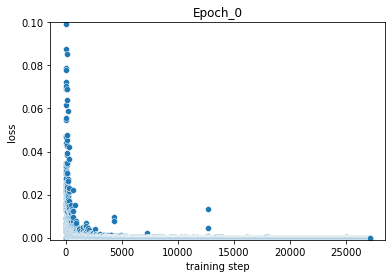

In [57]:
for e in logs.keys():
  sns.scatterplot(x=range(len(logs[e]['losses'])), 
                  y=logs[e]['losses']) 
  plt.title(e.capitalize())
  plt.xlabel('training step')
  plt.ylabel('loss')
  plt.ylim(-0.001,0.1)
  plt.show()

In [69]:
tloss = tf.reduce_sum(logs[e]['test_losses']).numpy() / (27113 / 7)
tmet = tf.reduce_sum(logs[e]['test_metrics']).numpy() / (27113 / 7)
print(f'Avg test loss: {tloss}')
print(f'Avg test accuracy: {tmet}')

Avg test loss: 4.243700105319207e-06
Avg test accuracy: 0.5089993729945045


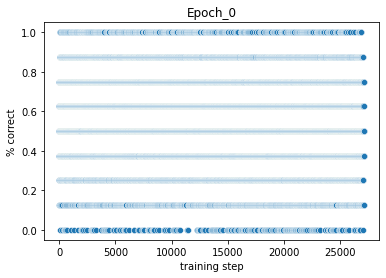

In [54]:
for e in logs.keys():
  sns.scatterplot(x=range(len(logs[e]['metrics'])), 
                  y=logs[e]['metrics'])
  plt.title(e.capitalize())
  plt.xlabel('training step')
  plt.ylabel('% correct')
  plt.show()